In [2]:
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import Image
from scipy import ndimage

# Canny Edge Detection

The Canny edge detection algorithm is composed of 5 steps:
1. Noise reduction;
2. Gradient calculation;
3. Non-maximum suppression;
4. Double threshold;
5. Edge Tracking by Hysteresis.

In [3]:
def visualize(imgs, titles):
    plt.figure(figsize=(15, 15))
    plt.gray() # show the filtered result in grayscale

    for i, img in enumerate(imgs):
        if img.shape[0] == 3:
            img = img.transpose(1,2,0)
        plt_idx = i+1
        plt.subplot(2, 2, plt_idx)
        plt.imshow(img)
        plt.title(str(titles[i]), size=20)
        plt.axis('off')

    plt.show()

def gaussian_kernel(size, sigma):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

In [4]:
image = cv2.imread('/content/eye-diagram.png')
image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

## Noise Reduction

In [5]:
g = gaussian_kernel(size=17, sigma=1)
image_gaussian = ndimage.filters.convolve(image_gray, g)


<ipython-input-5-48bd09f3954f>:2: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  image_gaussian = ndimage.filters.convolve(image_gray, g)


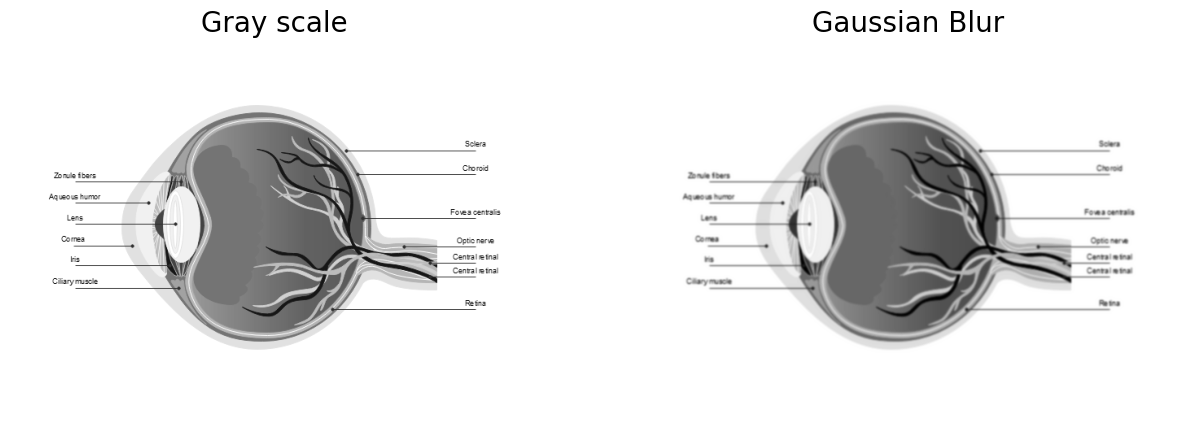

In [6]:

# display_result(image_gray, image_gaussian)
visualize([image_gray, image_gaussian], ["Gray scale", "Gaussian Blur"])

In [7]:
def sobel_filters(image_gaussian):
    filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) # filter for sobel edge detection

    img_sobelx = cv2.filter2D(image_gaussian, -1, filter)        # convolved with the vertical filter
    img_sobely = cv2.filter2D(image_gaussian, -1, np.flip(filter.T, axis=0)) # convolved with the horizontal filter

    image_G = np.hypot(img_sobelx, img_sobely)
    image_G = image_G / image_G.max() * 255

    theta = np.arctan2(img_sobely, img_sobelx)

    return image_G, theta

image_G, theta = sobel_filters(image_gaussian)


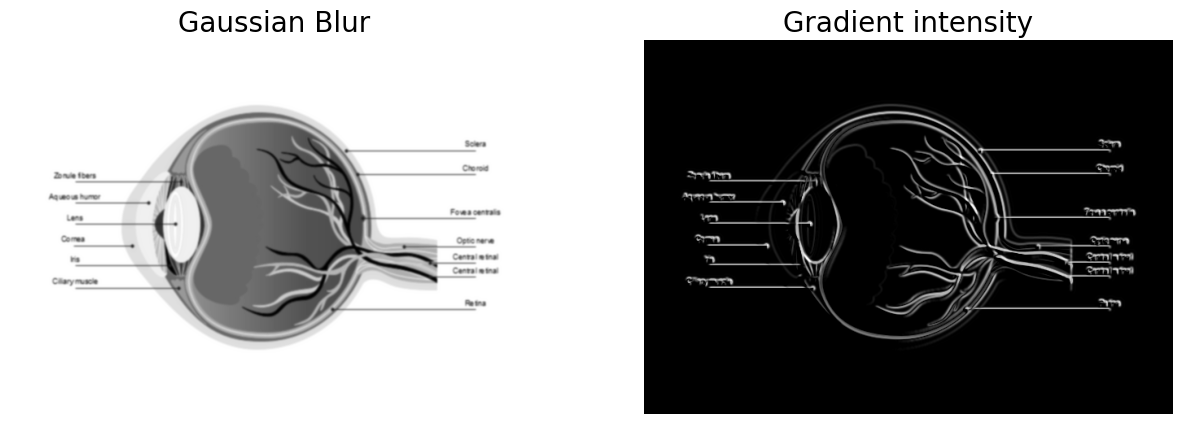

In [8]:
# display_result(image_gaussian, image_G)
visualize([image_gaussian, image_G], ["Gaussian Blur", "Gradient intensity"])


In [9]:
!sudo apt update
!sudo apt install tesseract-ocr
!pip install pytesseract

import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt

pytesseract.pytesseract.tesseract_cmd = (r'/usr/bin/tesseract')

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,517 kB]
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,796 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-security/universe 

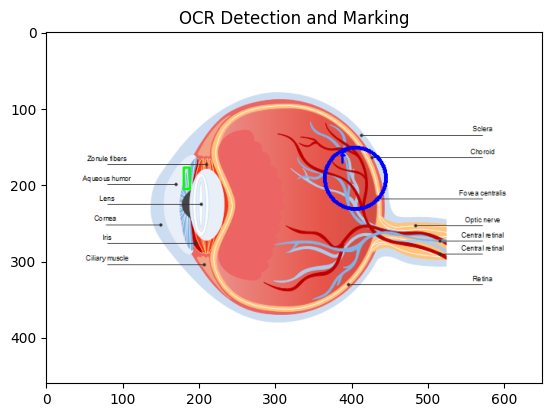

In [10]:
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt

original_image = cv2.imread('/content/eye-diagram.png')
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
image_gaussian = cv2.GaussianBlur(gray_image, (5, 5), 0)
image_G, theta = sobel_filters(image_gaussian)

custom_config = r'--oem 3 --psm 6'
detections = pytesseract.image_to_data(gray_image, config=custom_config, output_type=pytesseract.Output.DICT)

for i in range(len(detections['text'])):
    if int(detections['conf'][i]) > 60:
        (x, y, w, h) = (detections['left'][i], detections['top'][i], detections['width'][i], detections['height'][i])

        # Draw bounding box on the original image
        cv2.rectangle(original_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Determine if the text is in the left or right half
        mid_x = x + (w / 2)
        direction = -1 if mid_x > gray_image.shape[1] / 2 else 1

        # Find the nearest edge in the specified direction
        edge_x = np.argmax(image_G[y:y+h, x:x+w] if direction == 1 else np.fliplr(image_G[y:y+h, x:x+w]))
        if direction == -1:
            edge_x = w - edge_x

        # Calculate the position to draw the bigger circle
        circle_x = x + edge_x + (direction * w)
        circle_y = y + (h // 2)

        # Draw the bigger circle with the label of the identified text
        cv2.circle(original_image, (circle_x, circle_y), 40, (255, 0, 0), 3)
        cv2.putText(original_image, detections['text'][i], (circle_x - 20, circle_y - 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

# Visualize the image with bounding boxes and circles
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("OCR Detection and Marking")
plt.show()


## Non-Maximum Suppression

the final image should have thin edges.

Convert thick edges to thin edges

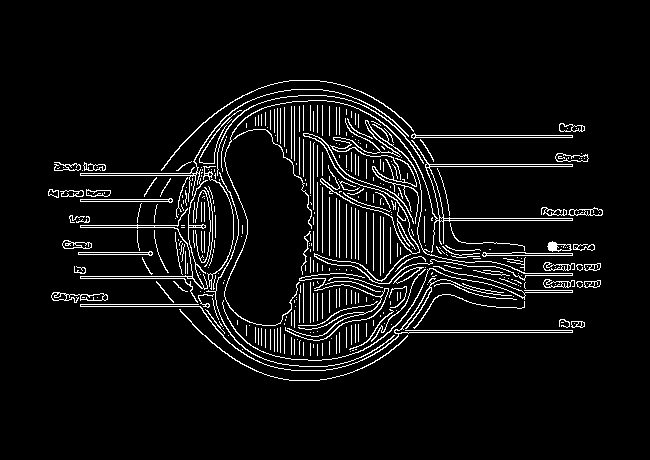

In [11]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

edges = cv2.Canny(image_gaussian, 1, 2)
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize an array to hold the centroid of potential markers
marker_centroids = []

for cnt in contours:
    # Calculate the area of the contour
    area = cv2.contourArea(cnt)

    # Find the circularity of the contour
    perimeter = cv2.arcLength(cnt, True)
    if perimeter == 0:
        continue  # Avoid division by zero
    circularity = 4 * np.pi * (area / (perimeter * perimeter))

    # Check if the circularity is within a specific range that represents a circle
    if 0.7 < circularity < 1.2:
        # Calculate the centroid of the contour
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            marker_centroids.append((cX, cY))
            # draw the centroid on the image
            cv2.circle(edges, (cX, cY), 5, (255, 255, 255), -1)


cv2_imshow(edges)
cv2.waitKey(0)
cv2.destroyAllWindows()



In [12]:
def non_max_suppression(image_G, theta):
    M, N = image_G.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255

                #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = image_G[i, j+1]
                    r = image_G[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = image_G[i+1, j-1]
                    r = image_G[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = image_G[i+1, j]
                    r = image_G[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = image_G[i-1, j-1]
                    r = image_G[i+1, j+1]

                if (image_G[i,j] >= q) and (image_G[i,j] >= r):
                    Z[i,j] = image_G[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    return Z

Z = non_max_suppression(image_G, theta)

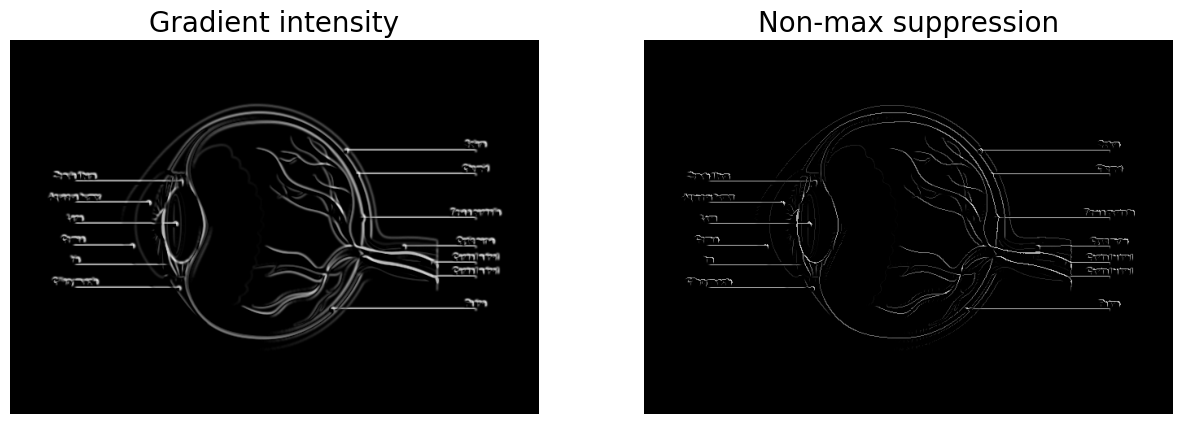

In [13]:
visualize([image_G, Z], ["Gradient intensity", "Non-max suppression"])